# Angle Recovery with GDM and Isomap

## Content

1. [Data Preparation](Read-Data)
2. [Geodesic Distance Matrix (GDM)](#Geodesic-Distance-Matrix)
3. [Isomap Embeddings](#Isomap)

## Read Data

Data used:
- Protein: 5a1a (symmetric protein)
- Projections: 5K
- Coverage: Half-sphere

![](figures/5a1a.pdb1-500.jpg)

In [1]:
import os
import h5py
import numpy as np
from time import time

import sys
sys.path.append("../..") 
from cryoem.plots import plot_angles_count, plot_euclidean_space, save_space_plot
from IPython.display import Image
from cryoem.plots import plot_rays, plot_angles_with_3rd_angle_magnitude

from cryoem.projections import RotationMatrix
import matplotlib.pyplot as plt
import ipyvolume as ipv

from sklearn.manifold import Isomap
import scipy

In [2]:
PROTEIN="5a1a"
ROOT_DIR = "../.."
NUM_PROJECTIONS = 5000

In [3]:
# location of *.h5 files
data_dir = f"{ROOT_DIR}/data"

# half coverage (AngCoverage=0.5)
projections_filename = f"{PROTEIN}_ProjectionsAngles_ProjNber5000_AngCoverage2.0,0.4,2.0_AngShift0.0,0.0,0.0.h5"

# load structures
data = h5py.File(os.path.join(data_dir, projections_filename), 'r')

print(f"{data['Projections'].shape[0]} projections of images with dimension {data['Projections'].shape[1:]} pixels")
print(f"{data['Angles'].shape[0]} sets of {data['Angles'].shape[1]} ground truth angles of corresponding projection images")

5000 projections of images with dimension (275, 275) pixels
5000 sets of 3 ground truth angles of corresponding projection images


### True Angles

In [4]:
angles_true = np.array(data['Angles'])
angles_true.shape

(5000, 3)

In [5]:
plot_angles_with_3rd_angle_magnitude(angles_true)

In [6]:
# arr = RotationMatrix(angles_true)

In [7]:
# fig, ax = plt.subplots(4,2, figsize=(8,12))
# ax[0,0].plot(arr[:,0], arr[:,1], marker="o", lw=0, markersize=1)
# ax[0,1].plot(arr[:,1], arr[:,2], marker="o", lw=0, markersize=1)
# ax[1,0].plot(arr[:,3], arr[:,4], marker="o", lw=0, markersize=1)
# ax[1,1].plot(arr[:,4], arr[:,5], marker="o", lw=0, markersize=1)
# ax[2,0].plot(arr[:,6], arr[:,7], marker="o", lw=0, markersize=1)
# ax[2,1].plot(arr[:,7], arr[:,8], marker="o", lw=0, markersize=1)
# ax[3,0].plot(arr[:,9], arr[:,10], marker="o", lw=0, markersize=1)
# ax[3,1].plot(arr[:,10], arr[:,11], marker="o", lw=0, markersize=1)
# plt.show()

### Euler angle to our Rotation Matrix

In [8]:
def euler2matrix(angles):
    c1 = np.cos(angles[:,0]).reshape(-1,1,1)
    c2 = np.cos(angles[:,1]).reshape(-1,1,1)
    c3 = np.cos(angles[:,2]).reshape(-1,1,1)
                
    s1 = np.sin(angles[:,0]).reshape(-1,1,1)
    s2 = np.sin(angles[:,1]).reshape(-1,1,1)
    s3 = np.sin(angles[:,2]).reshape(-1,1,1)
     
    R = np.concatenate([np.concatenate([c1*c2*c3-s1*s3, c1*s3+c2*c3*s1 , -c3*s2],axis=2),\
                    np.concatenate([-c3*s1-c1*c2*s3,    c1*c3-c2*s1*s3 ,   s2*s3],axis=2),\
                    np.concatenate( [c1*s2,             s1*s2          ,   c2],axis=2)],axis=1)
    return R

In [9]:
def d_R(M1, M2):
    """Distance between 2 rotation matirces"""
    R = M1 @ M2.T
    mid = (np.trace(R)-1)/2
    if mid > 1:
        mid = 1
    if mid < -1:
        mid = -1
    return np.arccos(mid)

In [10]:
R = euler2matrix(angles_true)
R.shape

(5000, 3, 3)

In [11]:
R_flatten = R.reshape(-1, 9)

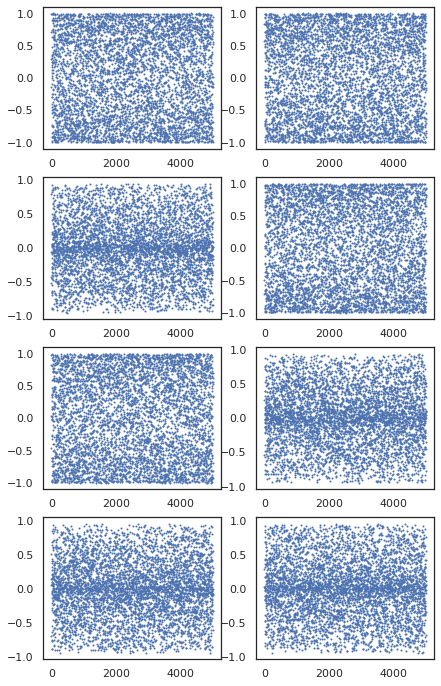

In [12]:
fig, ax = plt.subplots(4,2, figsize=(7,12))
x = range(len(R_flatten[:,1]))
ax[0,0].plot(x, R_flatten[:,0], marker="o", lw=0, markersize=1)
ax[0,1].plot(x, R_flatten[:,1], marker="o", lw=0, markersize=1)
ax[1,0].plot(x, R_flatten[:,2], marker="o", lw=0, markersize=1)
ax[1,1].plot(x, R_flatten[:,3], marker="o", lw=0, markersize=1)
ax[2,0].plot(x, R_flatten[:,4], marker="o", lw=0, markersize=1)
ax[2,1].plot(x, R_flatten[:,5], marker="o", lw=0, markersize=1)
ax[3,0].plot(x, R_flatten[:,6], marker="o", lw=0, markersize=1)
ax[3,1].plot(x, R_flatten[:,7], marker="o", lw=0, markersize=1)
plt.show()

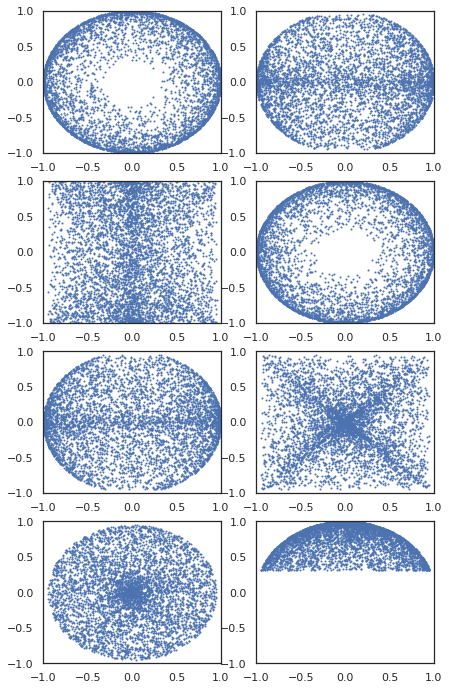

In [13]:
fig, ax = plt.subplots(4,2, figsize=(7,12))
ax[0,0].plot(R_flatten[:,0], R_flatten[:,1], marker="o", lw=0, markersize=1)
ax[0,1].plot(R_flatten[:,1], R_flatten[:,2], marker="o", lw=0, markersize=1)
ax[1,0].plot(R_flatten[:,2], R_flatten[:,3], marker="o", lw=0, markersize=1)
ax[1,1].plot(R_flatten[:,3], R_flatten[:,4], marker="o", lw=0, markersize=1)
ax[2,0].plot(R_flatten[:,4], R_flatten[:,5], marker="o", lw=0, markersize=1)
ax[2,1].plot(R_flatten[:,5], R_flatten[:,6], marker="o", lw=0, markersize=1)
ax[3,0].plot(R_flatten[:,6], R_flatten[:,7], marker="o", lw=0, markersize=1)
ax[3,1].plot(R_flatten[:,7], R_flatten[:,8], marker="o", lw=0, markersize=1)
plt.setp(ax, xlim=(-1, 1), ylim=(-1, 1))
plt.show()

In [14]:
d_R(R[3], R[3])

0.0

**Log:** Exporting to tangent space:

In [15]:
logR = np.array([scipy.linalg.logm(r) for r in R])

In [16]:
logR.shape

(5000, 3, 3)

In [17]:
logR_flatten = logR.reshape(-1, 9)

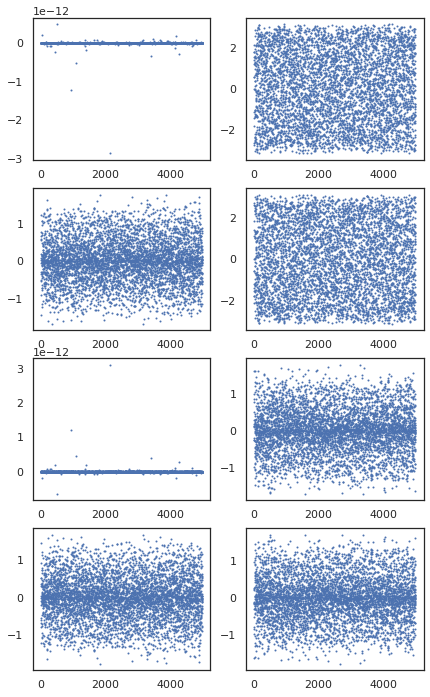

In [18]:
fig, ax = plt.subplots(4,2, figsize=(7,12))
x = range(len(logR_flatten[:,1]))
ax[0,0].plot(x, logR_flatten[:,0], marker="o", lw=0, markersize=1)
ax[0,1].plot(x, logR_flatten[:,1], marker="o", lw=0, markersize=1)
ax[1,0].plot(x, logR_flatten[:,2], marker="o", lw=0, markersize=1)
ax[1,1].plot(x, logR_flatten[:,3], marker="o", lw=0, markersize=1)
ax[2,0].plot(x, logR_flatten[:,4], marker="o", lw=0, markersize=1)
ax[2,1].plot(x, logR_flatten[:,5], marker="o", lw=0, markersize=1)
ax[3,0].plot(x, logR_flatten[:,6], marker="o", lw=0, markersize=1)
ax[3,1].plot(x, logR_flatten[:,7], marker="o", lw=0, markersize=1)
plt.show()

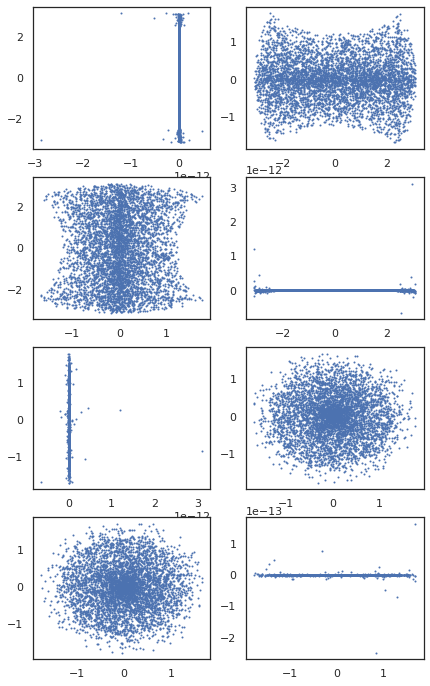

In [19]:
fig, ax = plt.subplots(4,2, figsize=(7,12))
ax[0,0].plot(logR_flatten[:,0], logR_flatten[:,1], marker="o", lw=0, markersize=1)
ax[0,1].plot(logR_flatten[:,1], logR_flatten[:,2], marker="o", lw=0, markersize=1)
ax[1,0].plot(logR_flatten[:,2], logR_flatten[:,3], marker="o", lw=0, markersize=1)
ax[1,1].plot(logR_flatten[:,3], logR_flatten[:,4], marker="o", lw=0, markersize=1)
ax[2,0].plot(logR_flatten[:,4], logR_flatten[:,5], marker="o", lw=0, markersize=1)
ax[2,1].plot(logR_flatten[:,5], logR_flatten[:,6], marker="o", lw=0, markersize=1)
ax[3,0].plot(logR_flatten[:,6], logR_flatten[:,7], marker="o", lw=0, markersize=1)
ax[3,1].plot(logR_flatten[:,7], logR_flatten[:,8], marker="o", lw=0, markersize=1)
# plt.setp(ax, xlim=(-1, 1), ylim=(-1, 1))
plt.show()

In [20]:
ipv.clear()
ipv.scatter(logR_flatten[:,1], logR_flatten[:,2], logR_flatten[:,5], marker="sphere")
# ipv.xlim(-20,20);ipv.ylim(-20,20);ipv.zlim(-20,20)
ipv.show()

**Exp:** Exporting to SO(3) space:

In [21]:
expR = np.array([scipy.linalg.expm(r) for r in R])

In [22]:
expR.shape

(5000, 3, 3)

In [23]:
expR_flatten = expR.reshape(-1, 9)

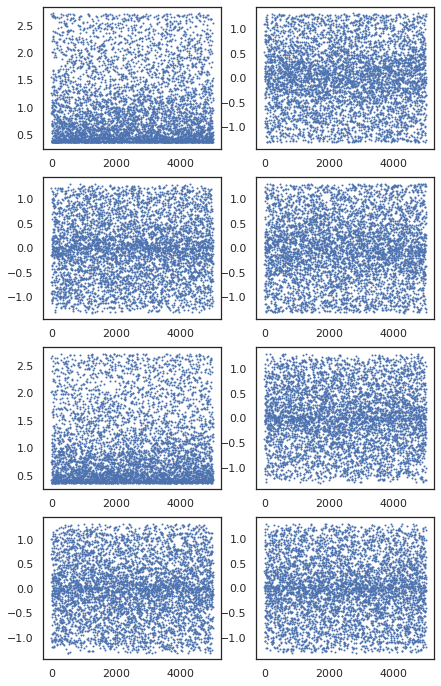

In [24]:
fig, ax = plt.subplots(4,2, figsize=(7,12))
x = range(len(expR_flatten[:,1]))
ax[0,0].plot(x, expR_flatten[:,0], marker="o", lw=0, markersize=1)
ax[0,1].plot(x, expR_flatten[:,1], marker="o", lw=0, markersize=1)
ax[1,0].plot(x, expR_flatten[:,2], marker="o", lw=0, markersize=1)
ax[1,1].plot(x, expR_flatten[:,3], marker="o", lw=0, markersize=1)
ax[2,0].plot(x, expR_flatten[:,4], marker="o", lw=0, markersize=1)
ax[2,1].plot(x, expR_flatten[:,5], marker="o", lw=0, markersize=1)
ax[3,0].plot(x, expR_flatten[:,6], marker="o", lw=0, markersize=1)
ax[3,1].plot(x, expR_flatten[:,7], marker="o", lw=0, markersize=1)
plt.show()

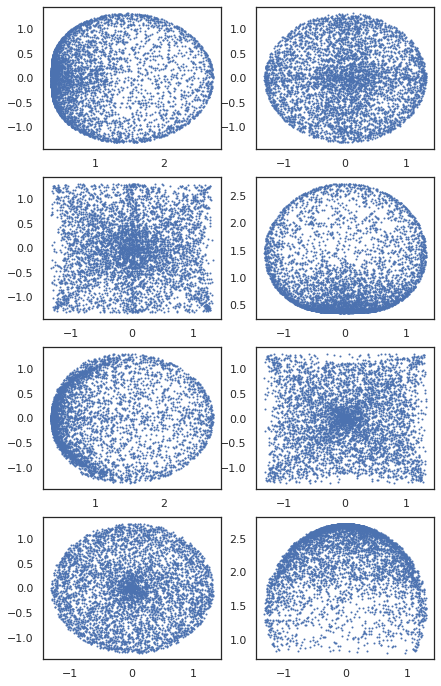

In [25]:
fig, ax = plt.subplots(4,2, figsize=(7,12))
ax[0,0].plot(expR_flatten[:,0], expR_flatten[:,1], marker="o", lw=0, markersize=1)
ax[0,1].plot(expR_flatten[:,1], expR_flatten[:,2], marker="o", lw=0, markersize=1)
ax[1,0].plot(expR_flatten[:,2], expR_flatten[:,3], marker="o", lw=0, markersize=1)
ax[1,1].plot(expR_flatten[:,3], expR_flatten[:,4], marker="o", lw=0, markersize=1)
ax[2,0].plot(expR_flatten[:,4], expR_flatten[:,5], marker="o", lw=0, markersize=1)
ax[2,1].plot(expR_flatten[:,5], expR_flatten[:,6], marker="o", lw=0, markersize=1)
ax[3,0].plot(expR_flatten[:,6], expR_flatten[:,7], marker="o", lw=0, markersize=1)
ax[3,1].plot(expR_flatten[:,7], expR_flatten[:,8], marker="o", lw=0, markersize=1)
# plt.setp(ax, xlim=(-1, 1), ylim=(-1, 1))
plt.show()

In [26]:
ipv.clear()
ipv.scatter(expR_flatten[:,0], expR_flatten[:,1], expR_flatten[:,2], marker="sphere")
# ipv.xlim(-20,20);ipv.ylim(-20,20);ipv.zlim(-20,20)
ipv.show()

## Rotation Matrix Distance Matrix

This is done using the kNN with geodesic distances between true angles. Later, when we start to use the real projections instead of true angles, we will be using the `projections` as input to kNN and the distance metric will be the one learned from the SiameseNN (`d_P`).

In [27]:
start_time = time()

A = np.zeros((len(R), len(R)))

for i in range(len(R)):
    for j in range(len(R)):
        A[i, j] = d_R(R[i], R[j])
        
print(f"--- {time() - start_time} seconds ---")

--- 260.75463819503784 seconds ---


In [28]:
A.shape

(5000, 5000)

In [29]:
# np.save(A, "data/quaternion_A.npy")

## Isomap

Embeding into 9-dim space

In [30]:
start_time = time()

embedding = Isomap(n_neighbors=4999, n_components=9)
A_transformed = embedding.fit_transform(A)

print(f"--- {time() - start_time} seconds ---")

--- 147.7253029346466 seconds ---


In [31]:
A_transformed.shape

(5000, 9)

# Main question here: if the input to Isomap is the distance matrix (i,j distance between 2 rotation matrices 3x3), what is the embedding coordinate?

Our expectations:
- we expect the embeddings to lie on a 2D manifold in some (unknown) embedding space.
- we are not yet sure what should be the dimension of the embedding space, defined with `n_components`
- from given triplets of rotation angles, is there a way to analytically calculate the coordinates of the manifold we get bellow?

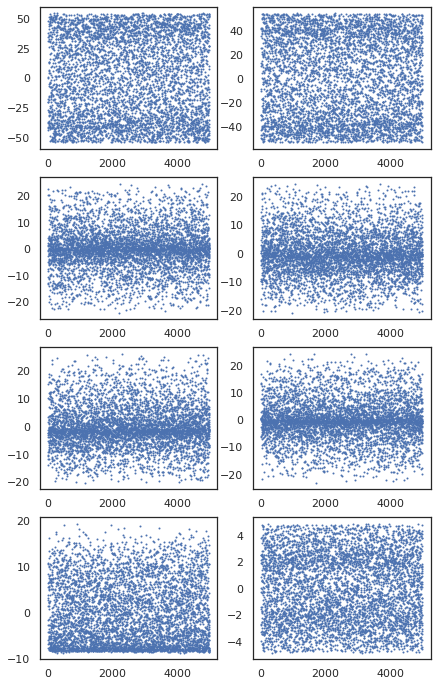

In [32]:
fig, ax = plt.subplots(4,2, figsize=(7,12))
x = range(len(A_transformed[:,1]))
ax[0,0].plot(x, A_transformed[:,0], marker="o", lw=0, markersize=1)
ax[0,1].plot(x, A_transformed[:,1], marker="o", lw=0, markersize=1)
ax[1,0].plot(x, A_transformed[:,2], marker="o", lw=0, markersize=1)
ax[1,1].plot(x, A_transformed[:,3], marker="o", lw=0, markersize=1)
ax[2,0].plot(x, A_transformed[:,4], marker="o", lw=0, markersize=1)
ax[2,1].plot(x, A_transformed[:,5], marker="o", lw=0, markersize=1)
ax[3,0].plot(x, A_transformed[:,6], marker="o", lw=0, markersize=1)
ax[3,1].plot(x, A_transformed[:,7], marker="o", lw=0, markersize=1)
plt.show()

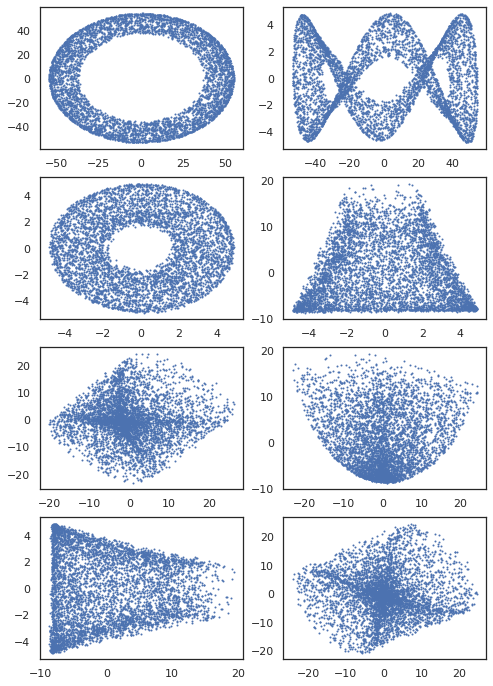

In [33]:
fig, ax = plt.subplots(4,2, figsize=(8,12))
ax[0,0].plot(A_transformed[:,0], A_transformed[:,1], marker="o", lw=0, markersize=1)
ax[0,1].plot(A_transformed[:,1], A_transformed[:,8], marker="o", lw=0, markersize=1)
ax[1,0].plot(A_transformed[:,8], A_transformed[:,7], marker="o", lw=0, markersize=1)
ax[1,1].plot(A_transformed[:,7], A_transformed[:,6], marker="o", lw=0, markersize=1)
ax[2,0].plot(A_transformed[:,4], A_transformed[:,5], marker="o", lw=0, markersize=1)
ax[2,1].plot(A_transformed[:,5], A_transformed[:,6], marker="o", lw=0, markersize=1)
ax[3,0].plot(A_transformed[:,6], A_transformed[:,7], marker="o", lw=0, markersize=1)
ax[3,1].plot(A_transformed[:,2], A_transformed[:,3], marker="o", lw=0, markersize=1)
plt.show()

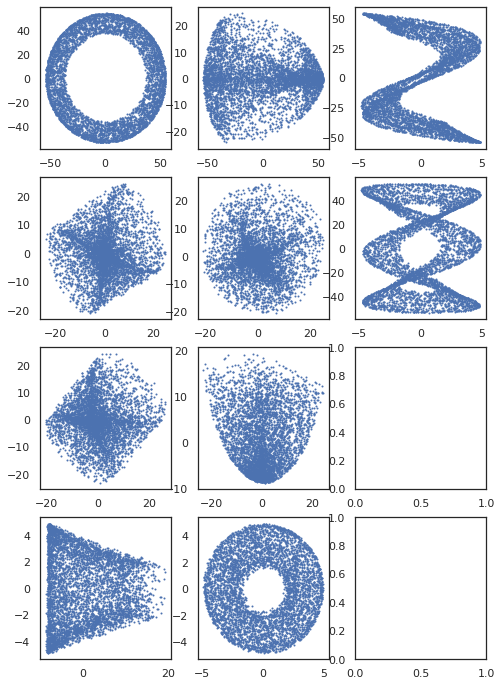

In [39]:
fig, ax = plt.subplots(4,3, figsize=(8,12))
ax[0,0].plot(A_transformed[:,0], A_transformed[:,1], marker="o", lw=0, markersize=1)
ax[0,1].plot(A_transformed[:,1], A_transformed[:,2], marker="o", lw=0, markersize=1)
ax[1,0].plot(A_transformed[:,2], A_transformed[:,3], marker="o", lw=0, markersize=1)
ax[1,1].plot(A_transformed[:,3], A_transformed[:,4], marker="o", lw=0, markersize=1)
ax[2,0].plot(A_transformed[:,4], A_transformed[:,5], marker="o", lw=0, markersize=1)
ax[2,1].plot(A_transformed[:,5], A_transformed[:,6], marker="o", lw=0, markersize=1)
ax[3,0].plot(A_transformed[:,6], A_transformed[:,7], marker="o", lw=0, markersize=1)
ax[3,1].plot(A_transformed[:,7], A_transformed[:,8], marker="o", lw=0, markersize=1)

ax[0,2].plot(A_transformed[:,8], A_transformed[:,0], marker="o", lw=0, markersize=1)
ax[1,2].plot(A_transformed[:,8], A_transformed[:,1], marker="o", lw=0, markersize=1)
plt.show()

In [160]:
A_transformed = A_transformed.reshape(-1, 9)

In [55]:
ipv.clear()
ipv.scatter(A_transformed[:,7], A_transformed[:,8], A_transformed[:,0], marker="sphere")
# ipv.xlim(-20,20);ipv.ylim(-20,20);ipv.zlim(-20,20)
ipv.show()

In [47]:
ipv.clear()
ipv.scatter(A_transformed[:,7], A_transformed[:,8], A_transformed[:,1], marker="sphere")
# ipv.xlim(-20,20);ipv.ylim(-20,20);ipv.zlim(-20,20)
ipv.show()

In [46]:
ipv.clear()
ipv.scatter(A_transformed[:,7], A_transformed[:,8], A_transformed[:,0], marker="sphere")
# ipv.xlim(-20,20);ipv.ylim(-20,20);ipv.zlim(-20,20)
ipv.show()

In [45]:
display(ipv.screenshot())

Output()

In [116]:
from pyquaternion import Quaternion
def euler2quaternion(angles):
    def _inner(a_z0, a_y, a_z1):
        q_z0 = Quaternion(axis=[0,0,1], angle=a_z0)
        q_y = Quaternion(axis=[0,1,0], angle=a_y)
        q_z1 = Quaternion(axis=[0,0,1], angle=a_z1)

        q = q_z0*q_y*q_z1
        return q #np.array([q.w, q.x, q.y, q.z])
    
    quaternions = []
    for a in angles:
        quaternions.append(_inner(a[0], a[1], a[2]))
    return np.array(quaternions)

In [117]:
qs = euler2quaternion(angles_true)
qs

array([Quaternion(-0.5150843253429189, -0.4036484128156413, 0.0820132165505552, -0.7516847270820894),
       Quaternion(0.921542733770055, -0.0646273861734725, 0.2510175294793733, 0.28908907050608185),
       Quaternion(-0.9961052018267462, 0.08405268500155627, -0.026636392724330254, -0.00027499156601945574),
       ...,
       Quaternion(0.6463079574972141, -0.08970449069007538, 0.5061118467283882, -0.5639946161329857),
       Quaternion(-0.13519210996829795, -0.16475079543686016, 0.27356246632682857, 0.9379466113923673),
       Quaternion(-0.7102262587826387, 0.03467838305658527, 0.40094727053250345, 0.5775961888177005)],
      dtype=object)

In [118]:
qs[0].w

-0.5150843253429189

In [119]:
A_transformed[:,7], A_transformed[:,8]

(array([ 2.55063834, -3.93759091,  2.16044606, ..., -2.62130748,
         1.36329106, -3.05701335]),
 array([ 1.77903427,  0.9436976 ,  4.19232871, ...,  0.23605597,
        -3.34361559, -0.27692449]))

In [120]:
pows = []
reals = []
imags = []

for q in qs:
    reals.append(q.w)
    imags.append(q.z)
    pows.append(pow(complex(q.w, q.z), 1/3).real)

pows = np.array(pows)
reals = np.array(reals)
imags = np.array(imags)

In [121]:
ipv.clear()
ipv.scatter(reals, imags, pows, marker="sphere")
# ipv.xlim(-20,20);ipv.ylim(-20,20);ipv.zlim(-20,20)
ipv.show()

In [115]:
display(ipv.screenshot())

Output()

**SIMILAR TO RIEMANNIAN SURFACE!!!!***

**Log:** Exporting to tangent space:

In [178]:
# A_transformed = A_transformed.reshape(-1, 3, 3)

In [179]:
# logA_transformed = np.array([scipy.linalg.logm(r) for r in A_transformed])

In [180]:
# logA_transformed.shape

In [181]:
# logA_transformed_flatten = logA_transformed.reshape(-1, 9)

In [182]:
# fig, ax = plt.subplots(4,2, figsize=(7,12))
# x = range(len(logR_flatten[:,1]))
# ax[0,0].plot(x, logA_transformed_flatten[:,0], marker="o", lw=0, markersize=1)
# ax[0,1].plot(x, logA_transformed_flatten[:,1], marker="o", lw=0, markersize=1)
# ax[1,0].plot(x, logA_transformed_flatten[:,2], marker="o", lw=0, markersize=1)
# ax[1,1].plot(x, logA_transformed_flatten[:,3], marker="o", lw=0, markersize=1)
# ax[2,0].plot(x, logA_transformed_flatten[:,4], marker="o", lw=0, markersize=1)
# ax[2,1].plot(x, logA_transformed_flatten[:,5], marker="o", lw=0, markersize=1)
# ax[3,0].plot(x, logA_transformed_flatten[:,6], marker="o", lw=0, markersize=1)
# ax[3,1].plot(x, logA_transformed_flatten[:,7], marker="o", lw=0, markersize=1)
# plt.show()

In [183]:
# fig, ax = plt.subplots(4,2, figsize=(7,12))
# ax[0,0].plot(logA_transformed_flatten[:,0], logA_transformed_flatten[:,1], marker="o", lw=0, markersize=1)
# ax[0,1].plot(logA_transformed_flatten[:,1], logA_transformed_flatten[:,2], marker="o", lw=0, markersize=1)
# ax[1,0].plot(logA_transformed_flatten[:,2], logA_transformed_flatten[:,3], marker="o", lw=0, markersize=1)
# ax[1,1].plot(logA_transformed_flatten[:,3], logA_transformed_flatten[:,4], marker="o", lw=0, markersize=1)
# ax[2,0].plot(logA_transformed_flatten[:,4], logA_transformed_flatten[:,5], marker="o", lw=0, markersize=1)
# ax[2,1].plot(logA_transformed_flatten[:,5], logA_transformed_flatten[:,6], marker="o", lw=0, markersize=1)
# ax[3,0].plot(logA_transformed_flatten[:,6], logA_transformed_flatten[:,7], marker="o", lw=0, markersize=1)
# ax[3,1].plot(logA_transformed_flatten[:,7], logA_transformed_flatten[:,8], marker="o", lw=0, markersize=1)
# # plt.setp(ax, xlim=(-1, 1), ylim=(-1, 1))
# plt.show()

In [146]:
# ipv.clear()
# ipv.scatter(logA_transformed_flatten[:,0], logA_transformed_flatten[:,1], logA_transformed_flatten[:,2], marker="sphere")
# # ipv.xlim(-20,20);ipv.ylim(-20,20);ipv.zlim(-20,20)
# ipv.show()

**Exp:** Exporting to SO(3) space:

In [184]:
# expA_transformed = np.array([scipy.linalg.expm(r) for r in A_transformed])

In [185]:
# expA_transformed.shape

In [186]:
# expA_transformed_flatten = expA_transformed.reshape(-1, 9)

In [187]:
# fig, ax = plt.subplots(4,2, figsize=(7,12))
# x = range(len(expA_transformed_flatten[:,1]))
# ax[0,0].plot(x, expA_transformed_flatten[:,0], marker="o", lw=0, markersize=1)
# ax[0,1].plot(x, expA_transformed_flatten[:,1], marker="o", lw=0, markersize=1)
# ax[1,0].plot(x, expA_transformed_flatten[:,2], marker="o", lw=0, markersize=1)
# ax[1,1].plot(x, expA_transformed_flatten[:,3], marker="o", lw=0, markersize=1)
# ax[2,0].plot(x, expA_transformed_flatten[:,4], marker="o", lw=0, markersize=1)
# ax[2,1].plot(x, expA_transformed_flatten[:,5], marker="o", lw=0, markersize=1)
# ax[3,0].plot(x, expA_transformed_flatten[:,6], marker="o", lw=0, markersize=1)
# ax[3,1].plot(x, expA_transformed_flatten[:,7], marker="o", lw=0, markersize=1)
# plt.show()

In [188]:
# fig, ax = plt.subplots(4,2, figsize=(7,12))
# ax[0,0].plot(expA_transformed_flatten[:,0], expA_transformed_flatten[:,1], marker="o", lw=0, markersize=1)
# ax[0,1].plot(expA_transformed_flatten[:,1], expA_transformed_flatten[:,2], marker="o", lw=0, markersize=1)
# ax[1,0].plot(expA_transformed_flatten[:,2], expA_transformed_flatten[:,3], marker="o", lw=0, markersize=1)
# ax[1,1].plot(expA_transformed_flatten[:,3], expA_transformed_flatten[:,4], marker="o", lw=0, markersize=1)
# ax[2,0].plot(expA_transformed_flatten[:,4], expA_transformed_flatten[:,5], marker="o", lw=0, markersize=1)
# ax[2,1].plot(expA_transformed_flatten[:,5], expA_transformed_flatten[:,6], marker="o", lw=0, markersize=1)
# ax[3,0].plot(expA_transformed_flatten[:,6], expA_transformed_flatten[:,7], marker="o", lw=0, markersize=1)
# ax[3,1].plot(expA_transformed_flatten[:,7], expA_transformed_flatten[:,8], marker="o", lw=0, markersize=1)
# # plt.setp(ax, xlim=(-1, 1), ylim=(-1, 1))
# plt.show()

In [189]:
# ipv.clear()
# ipv.scatter(expA_transformed_flatten[:,0], expA_transformed_flatten[:,1], expA_transformed_flatten[:,5], marker="sphere")
# # ipv.xlim(-20,20);ipv.ylim(-20,20);ipv.zlim(-20,20)
# ipv.show()

In [107]:
display(ipv.screenshot())

Output()

In [23]:
def mat2quat(R):
    e0_sq = 1/4*(1+np.trace(R))
    e0 = np.sqrt(e0_sq)
    if e0_sq >0:
        e1 = 1/(4*e0)*(R[2,1]-R[1,2])
        e2 = 1/(4*e0)*(R[0,2]-R[2,0])
        e3 = 1/(4*e0)*(R[1,0]-R[0,1])
    else:
        e1_sq = -1/2*(R[1,1]+R[2,2])
        e1 = np.sqrt(e1_sq)
        if e1_sq > 0:
            e2 = R[0,1]/(2*e1)
            e3 = R[0,2]/(2*e1)
        else:
            e2_sq = 1/2*(1-R[2,2])
            e2 = np.sqrt(e2_sq)
            if e2_sq > 0:
                e3 = R[1,2]/(2*e2)
            else:
                e3 = 1
    return Quaternion(w=e0, x=e1, y=e2, z=e3).normalised

In [86]:
def f_GS(R):
    """6D to SO(3)"""
    # make 3x2 matrix
    a1 = R[:,0]
    a2 = R[:,1]

    b1 = a1/np.linalg.norm(a1)
    b2 = a2 - np.dot(b1,a2)*b1
    b2 = b2/np.linalg.norm(b2)
    b3 = np.cross(b1, b2)
    # ERROR: resulting matrix should be orthogonal!!!!!!!!!!!!!!!!!!
    return np.column_stack((b1, b2, b3)).astype(np.float32)

In [87]:
def g_GS(X):
    """SO(3) to 6D"""
    a1 = X[:,0]
    a2 = X[:,1]
    a3 = X[:,2]
    
    return np.column_stack((a1, a2)).astype(np.float32)

In [88]:
def f_q(q):
    # TODO: fix here!!!
    return q.normalised.rotation_matrix  #np.around(q.normalised.rotation_matrix, decimals=9)

In [89]:
def g_q(M):
    # TODO: fix here!!!!
    #return -Quaternion(matrix=M).normalised
    return mat2quat(M)

In [90]:
print("q =\n", quaternions[0])
M = f_q(quaternions[0])
print("M =\n", M)
q = g_q(M)
print("q =\n", q)

q =
 -0.148 +0.191i +0.397j -0.885k
M =
 [[-0.8836099  -0.10962853 -0.45520889]
 [ 0.41293403 -0.64075925 -0.64723494]
 [-0.22072389 -0.75987445  0.61145056]]
q =
 0.148 -0.191i -0.397j +0.885k


In [91]:
R = A_transformed[0].reshape((3,2))
print("R =\n", R)
X = f_GS(R)
print("X =\n", X)

print("Complains X is not orthogonal, but it is! Floating point problem")
X_tr = X.T  #np.around(X.T, decimals=6)
X_inv = np.linalg.inv(X)  #np.around(np.linalg.inv(X), decimals=6)
print("X.T =\n", X_tr)
print("X.inverse =\n", X_inv)
print(X_tr == X_inv)
print(np.allclose(np.dot(X, X.conj().transpose()), np.eye(3)))
print(np.dot(X, X.conj().transpose()))

q = g_q(X)
print(q)

R = g_GS(X)
print("R =\n", R)
X = f_GS(R)
print("X =\n", X)
# q = g_q(X)
# q

R =
 [[61.30281997  6.94479674]
 [17.66567153  8.19085143]
 [ 6.06272282  7.57070429]]
X =
 [[ 0.9565883  -0.25190893  0.14656301]
 [ 0.27566063  0.6188133  -0.7355823 ]
 [ 0.09460462  0.7440511   0.6613909 ]]
Complains X is not orthogonal, but it is! Floating point problem
X.T =
 [[ 0.9565883   0.27566063  0.09460462]
 [-0.25190893  0.6188133   0.7440511 ]
 [ 0.14656301 -0.7355823   0.6613909 ]]
X.inverse =
 [[ 0.95658827  0.27566063  0.09460461]
 [-0.25190893  0.6188133   0.7440511 ]
 [ 0.14656301 -0.73558235  0.6613909 ]]
[[False  True False]
 [ True  True  True]
 [ True False  True]]
False
[[ 1.0000000e+00  9.9566906e-09 -3.4398209e-09]
 [ 9.9566906e-09  9.9999994e-01  4.0743238e-08]
 [-3.4398209e-09  4.0743238e-08  1.0000000e+00]]
0.900 +0.411i +0.014j +0.147k
R =
 [[ 0.9565883  -0.25190893]
 [ 0.27566063  0.6188133 ]
 [ 0.09460462  0.7440511 ]]
X =
 [[ 0.9565883  -0.25190893  0.14656301]
 [ 0.27566063  0.6188133  -0.7355823 ]
 [ 0.09460462  0.7440511   0.66139096]]


In [92]:
(f_GS(g_GS(X)) == X).all()

True

In [93]:
(g_GS(f_GS(R)) == R).all()

True

---

This is expected 6D elemenents from true quaternion

In [94]:
q = quaternions[0]
q

Quaternion(-0.14754780530982708, 0.19085255370786888, 0.3973034383464813, -0.8854122914041245)

In [95]:
X = f_q(q)
R = g_GS(X)
R

array([[-0.8836099 , -0.10962853],
       [ 0.41293404, -0.6407592 ],
       [-0.2207239 , -0.75987446]], dtype=float32)

We expect the embedding to be R matrix (3x2)

In [96]:
A_transformed[0].reshape((3,2))

array([[61.30281997,  6.94479674],
       [17.66567153,  8.19085143],
       [ 6.06272282,  7.57070429]])

In [97]:
R = A_transformed[0].reshape((3,2))
X = f_GS(R)
q = g_q(X)
q

Quaternion(0.8995544150225051, 0.4112128501612207, 0.014440035255441606, 0.14661968373184303)

In [98]:
from scipy.spatial.transform import Rotation as R

r = R.from_quat([q.x, q.y, q.z, q.w])
r.as_euler("zyz"), angles_true[0]

(array([ 1.69726571,  0.84812457, -1.37412435]),
 array([4.09944284, 0.91290385, 4.99508373]))

In [99]:
# TODO do for all

In [116]:
from scipy.spatial.transform import Rotation as R

def emb2angle(emb):
    def _inner(e):
        R_mat = e.reshape((3,2))
        X = f_GS(R_mat)
        q = g_q(X)
        r = R.from_quat([q.x, q.y, q.z, q.w])
        a = r.as_euler("zyz")
        return a
#         try:
#             q = g_q(X)
#             r = R.from_quat([q.x, q.y, q.z, q.w])
#             a = r.as_euler("zyz")
#             return a
#         except ValueError:
#             return None
    
    angles = []
    indices = []
    for i, e in enumerate(emb):
        a = _inner(e)
        if a is not None:
            angles.append(a)
            indices.append(i)
    return np.array(angles), indices

In [117]:
angles_emb, indices = emb2angle(A_transformed)

In [118]:
angles_emb.shape

(5000, 3)

In [119]:
at = np.take(angles_true, indices, axis=0)
at[0], angles_emb[0]

(array([4.09944284, 0.91290385, 4.99508373]),
 array([ 1.69726571,  0.84812457, -1.37412435]))

In [120]:
at[-1], angles_emb[-1]

(array([0.57449347, 0.28630611, 5.4732492 ]),
 array([-2.28567964,  0.63453128, -1.39470321]))

In [121]:
plot_euclidean_space(np.take(angles_true, indices, axis=0))

In [131]:
angles_emb

array([[ 1.69726571,  0.84812457, -1.37412435],
       [-1.40293955,  3.04554829,  1.38928835],
       [ 3.11365334,  1.7348946 , -1.22032113],
       ...,
       [-1.49721595,  0.59614363,  1.45134436],
       [-1.16532022,  0.11715644,  1.35554041],
       [-2.28567964,  0.63453128, -1.39470321]])

In [136]:
ipv.clear()
ipv.plot(angles_emb[:,0], angles_emb[:,1], angles_emb[:,1], marker="o", lw=0)
ipv.show()

In [108]:
display(ipv.screenshot())

Output()

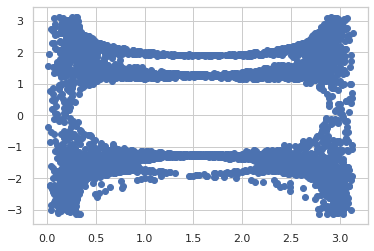

In [130]:
plt.plot(angles_emb[:,1], angles_emb[:,2], marker="o", lw=0)